# CHI 2018 Author and Reviewer Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

authors = pd.read_csv("../data/listOfAuthors-papers.csv", encoding='latin1', quotechar="\"", index_col='Paper-Author')

#Remove unnecessary fields
del authors['ins2']
del authors['middle_initial']

#Clean dataset
authors.email = authors.email.astype(str)
authors.email = authors.email.str.lower()

#Encode to UTF-8
authors.email = authors.email.str.strip()
authors.given_name = authors.given_name.str.strip()
authors.family_name = authors.family_name.str.strip()
authors.ins1 = authors.ins1.str.strip()

In [2]:
reviewers = pd.read_csv("../data/listOfReviewers-papers.csv", encoding='latin1', header=0, index_col='ID')
reviewers = reviewers.loc[:,['role','review_submitted','review_assigned','family_name','given_name','middle_initial','email','dep1','ins1', 'country1']]

#Clean dataset
reviewers.email = reviewers.email.astype(str)
reviewers.ins1 = reviewers.ins1.astype(str)
reviewers.country1 = reviewers.country1.astype(str)
reviewers.email = reviewers.email.str.lower()

#Encode to UTF-8
reviewers.email = reviewers.email.str.encode('utf8')
reviewers.ins1 = reviewers.ins1.str.replace("\"", "")
reviewers.country1 = reviewers.country1.str.replace("\"", "")
reviewers.ins1 = reviewers.ins1.str.strip()
reviewers.country1 = reviewers.country1.str.strip()

reviewers.email = reviewers.email.str.decode('utf8').replace('b"b\'', '').replace('\'"', '')

# How many reviewers submitted less than assigned?

In [3]:
reviewers_less_sub = reviewers.query('review_submitted < review_assigned')

In [4]:
reviewers_less_sub.count()

role                46
review_submitted    46
review_assigned     46
family_name         46
given_name          46
middle_initial       4
email               46
dep1                24
ins1                46
country1            46
dtype: int64

In [5]:
reviewers.query('review_submitted < review_assigned').groupby('role').count()

,review_submitted,review_assigned,family_name,given_name,middle_initial,email,dep1,ins1,country1
role,,,,,,,,,
committee,24,24,24,24,1,24,12,24,24
reviewer,22,22,22,22,3,22,12,22,22


# How many reviewers did not submit at all?

In [6]:
reviewers_zero = reviewers.query('review_submitted == 0 & review_assigned > 0')

In [7]:
reviewers_zero.groupby('role').count()

,review_submitted,review_assigned,family_name,given_name,middle_initial,email,dep1,ins1,country1
role,,,,,,,,,
committee,2,2,2,2,0,2,1,2,2
reviewer,16,16,16,16,2,16,7,16,16


In [8]:
reviewers.query('review_submitted == 0 & review_assigned > 0 & role == "reviewer"').groupby('review_assigned')['role'].count()

review_assigned
1    15
2     1
Name: role, dtype: int64

In [9]:
reviewers.query('review_submitted == 0 & review_assigned > 0 & role == "committee"').groupby('review_assigned')['role'].count()

review_assigned
1     1
15    1
Name: role, dtype: int64

In [10]:
reviewers_notassigned = reviewers.query('review_assigned == 0')

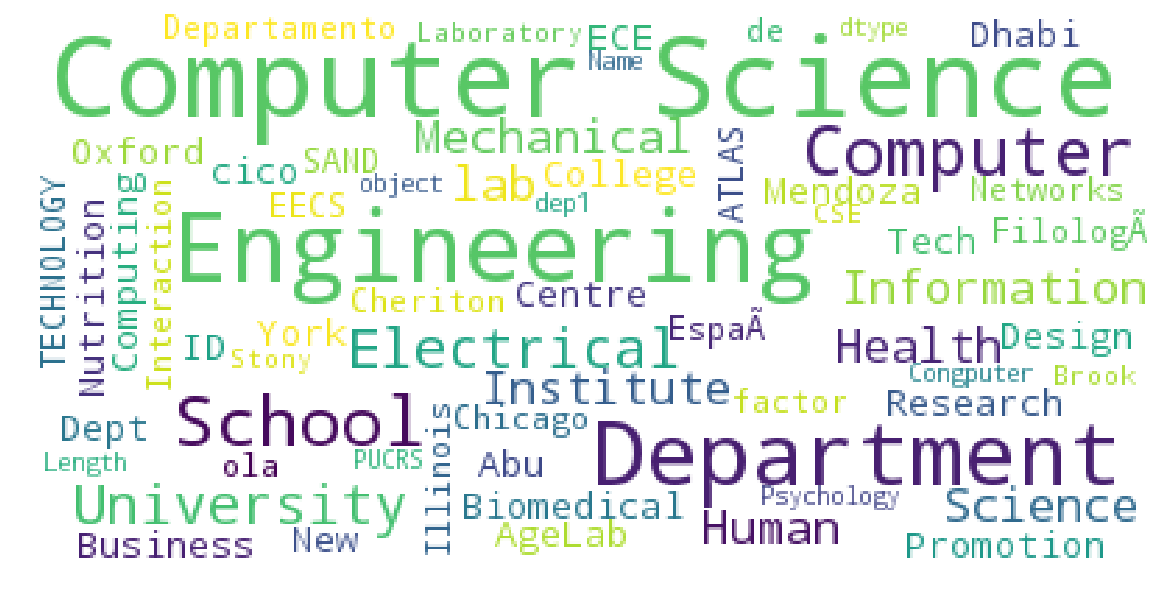

In [12]:
# https://www.kaggle.com/y983zhan/word-cloud-with-python

stopwords = set(STOPWORDS)
stopwords.add('NaN')

reviewer_notassigned_dept_wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=200, 
                          random_state=42
                         ).generate(str(reviewers.query('review_assigned == 0')['dep1']))

mpl.rcParams['figure.figsize']=(20.0,20.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=900             #72 
mpl.rcParams['figure.subplot.bottom']=.1 

reviewer_notassigned_dept_fig = plt.figure(1)
plt.imshow(reviewer_notassigned_dept_wordcloud)
plt.axis('off')
plt.show()
reviewer_notassigned_dept_fig.savefig("reviewer_notassigned_dept_fig.png", dpi=900)

In [13]:
reviewers_notassigned.groupby('role').count()

,review_submitted,review_assigned,family_name,given_name,middle_initial,email,dep1,ins1,country1
role,,,,,,,,,
committee,28,28,28,28,4,28,16,28,28
reviewer,2267,2267,2267,2267,386,2267,1492,2267,2267


# How did the authors review?

Out of all the authors who submitted, how many were assigned reviews? How many submitted reviews? Are we utilizing all the authors for the review process?

First, let's get the authors that were assigned papers to review.

In [14]:
#Clean data
unique_authors = pd.DataFrame({'email': authors.groupby('email').decision.count().keys(), 'submissions': authors.groupby('email').decision.count().values})
unique_authors.email = unique_authors.email.astype(str)
unique_authors.email = unique_authors.email.str.strip()

In [15]:
#All authors who appeared in the Reviewer database.
author_reviewers_raw = pd.merge(unique_authors, reviewers, left_on='email', right_on='email', how='inner')

In [16]:
author_reviewers = author_reviewers_raw.query('review_assigned > 0').sort_values(by=['email'])
print("==============Authors who were assigned as reviewers===============\n")
print("Author reviewers: ", author_reviewers.email.count())
print("Average papers assigned per author: ", author_reviewers.review_assigned.mean())
print("Average submissions per reviewer: ", author_reviewers.review_submitted.mean())

==============Authors who were assigned as reviewers===============

Author reviewers:  1323
Average papers assigned per author:  4.578231292517007
Average submissions per reviewer:  4.546485260770975


In [17]:
author_reviewers_prob = author_reviewers_raw.query('review_assigned > 0 & review_submitted < review_assigned')
print("==============Author reviewers who submitted less than assigned===============\n")
print("Author reviewers: ", author_reviewers_prob.email.count())
print("Average papers assigned per author: ", author_reviewers_prob.review_assigned.mean())
print("Average submissions per reviewer: ", author_reviewers_prob.review_submitted.mean())

==============Author reviewers who submitted less than assigned===============

Author reviewers:  25
Average papers assigned per author:  13.28
Average submissions per reviewer:  11.6


In [18]:
author_reviewers_more = author_reviewers_raw.query('review_assigned > 0 & review_submitted >= review_assigned')
print("==============Author reviewers who submitted more than assigned===============\n")
print("Author reviewers: ", author_reviewers_more.email.count())
print("Average papers assigned per author: ", author_reviewers_more.review_assigned.mean())
print("Average submissions per reviewer: ", author_reviewers_more.review_submitted.mean())

==============Author reviewers who submitted more than assigned===============

Author reviewers:  1298
Average papers assigned per author:  4.410631741140215
Average submissions per reviewer:  4.410631741140215


In [19]:
# Authors who were NOT assigned any papers to review
author_only = author_reviewers_raw.query('review_assigned == 0')
print("==============Author reviewers who were not assigned===============\n")
print("Authors: ", author_only.email.count())

==============Author reviewers who were not assigned===============

Authors:  719


In [20]:
reviewassigned_per_role = author_reviewers.groupby(['review_assigned', 'review_submitted', 'role'])
reviewassigned_per_role.count()

email  submissions  family_name  \
review_assigned review_submitted role                                         
1               0                reviewer       2            2            2   
                1                committee      7            7            7   
                                 reviewer     466          466          466   
2               1                reviewer       2            2            2   
                2                committee      3            3            3   
                                 reviewer     255          255          255   
3               2                reviewer       1            1            1   
                3                committee      1            1            1   
                                 reviewer     150          150          150   
4               4                reviewer     123          123          123   
5               5                reviewer      55           55           55   
6               5                reviewer       1            1            1   
                6                reviewer      31           31           31   
7               5                reviewer       1            1            1   
                7                reviewer      14           14           14   
8               8                reviewer       6            6            6   
9               9                reviewer       5            5            5   
10              10               reviewer       2            2            2   
12              12               reviewer       1            1            1   
13              13               committee      1            1            1   
                                 reviewer       1            1            1   
15              0                committee      1            1            1   
                15               committee      7            7            7   
16              14               committee      1            1            1   
                15               committee      2            2            2   
                16               committee     46           46           46   
17              16               committee      8            8            8   
                17               committee     50           50           50   
18              17               committee      4            4            4   
                18               committee     40           40           40   
19              18               committee      1            1            1   
                19               committee     17           17           17   
20              18               committee      1            1            1   
                20               committee     12           12           12   
21              21               committee      3            3            3   
22              22               committee      2            2            2   

                                            given_name  middle_initial  dep1  \
review_assigned review_submitted role                                          
1               0                reviewer            2               0     0   
                1                committee           7               3     3   
                                 reviewer          466              75   354   
2               1                reviewer            2               0     2   
                2                committee           3               0     1   
                                 reviewer          255              51   195   
3               2                reviewer            1               0     1   
                3                committee           1               0     0   
                                 reviewer          150              18   102   
4               4                reviewer          123              27    81   
5               5                reviewer           55              16    32   
6

# How many authors reviewed less than their submissions?

In [21]:
author_reviewers_less_sub = author_reviewers.query('submissions > review_submitted')

In [22]:
author_reviewers_less_sub_assigned = author_reviewers.query('submissions > review_submitted & review_submitted < review_assigned')

In [23]:
#Save some results to CSVs

author_reviewers.to_csv('../output/author_reviewers.csv')
author_reviewers_less_sub_assigned.to_csv('../output/author_reviewers_less_sub_assigned.csv')
author_reviewers_more.to_csv('../output/author_reviewers_more.csv')
author_reviewers_less_sub.to_csv('../output/author_reviewers_less_sub.csv')
author_reviewers_less_sub_assigned.to_csv('../output/author_reviewers_less_sub_assigned.csv')
author_reviewers_prob.to_csv('../output/author_reviewers_prob.csv')